In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from functools import partial, reduce
from itertools import product

from polling_simulator import Demographic, Variable, generate_electorate, run_elections, run_polls
from polling_simulator.aggregation import naive_aggregation, stratified_aggregation, weight_by_self_reported_turnout
from polling_simulator.core import Segmentation
from polling_simulator.distributions import truncated_gaussian_distribution
from polling_simulator.sampling import predefined_sample, guaranteed_sample

original_palette = sns.color_palette()
modified_palette = [original_palette[0], original_palette[3]]
sns.set_palette(modified_palette)

Starting back with the example from the previous notebook.

In [24]:
age = Variable("age", truncated_gaussian_distribution(18, 35, 18, 110))
education = Variable("education", partial(
    np.random.choice, np.array(["High School", "College", "Post-College"]), replace=True, p=np.array([0.4, 0.4, 0.2])
))

In [25]:
@dataclass
class Parameterization:
    segment: Segmentation
    republican_modifier: float
    turnout_modifier: float = 1
    response_modifier: float = 1

age_parameterization = [
    Parameterization(age < 30, 0.5),
    Parameterization((age >= 30) & (age < 50), 0.9),
    Parameterization((age >= 50) & (age < 65), 1.2),
    Parameterization(age >= 65, 1.5)
]
education_parameterization = [
    Parameterization(education == "High School", 1.5, response_modifier=0.2),
    Parameterization(education == "College", 1),
    Parameterization(education == "Post-College", 0.5)
]
def generate_demographics(
    default_turnout_likelihood, default_response_likelihood, default_republican_likelihood, *parameterizations
):
    demographics = []
    for param_combo in product(*parameterizations):
        turnout_likelihood = default_turnout_likelihood * reduce(
            lambda x, y: x * y,
            [param.turnout_modifier for param in param_combo]
        )
        response_likelihood = default_response_likelihood * reduce(
            lambda x, y: x * y,
            [param.response_modifier for param in param_combo]
        )
        republican_likelihood = default_republican_likelihood * reduce(
            lambda x, y: x * y,
            [param.republican_modifier for param in param_combo]
        )
        turnout_likelihood = 1 if turnout_likelihood > 1 else turnout_likelihood
        response_likelihood = 1 if response_likelihood > 1 else response_likelihood
        republican_likelihood = 1 if republican_likelihood > 1 else republican_likelihood
        democrat_likelihood = 1 - republican_likelihood
        demographics.append(
            Demographic(
                turnout_likelihood=turnout_likelihood,
                response_likelihood=response_likelihood,
                candidate_preference={"Republican": republican_likelihood, "Democrat": democrat_likelihood},
                population_segmentation=reduce(lambda x, y: x & y, [param.segment for param in param_combo])
            )
        )
    return demographics
    
actual_demographics = generate_demographics(
    0.5, 0.5, 0.5,
    age_parameterization, education_parameterization
)
assumed_demographics = generate_demographics(
    0.5, 0.5, 0.5,
    age_parameterization
)

In [4]:
def print_demographics(demographics):
    print(f"{'Segmentation':>60} | Turnout | Response |  Democrat |  Republican")
    for demographic in demographics:
        segmentation_string = str(demographic.population_segmentation)
        republican_likelihood = demographic.candidate_preference["Democrat"]
        democrat_likelihood = demographic.candidate_preference["Republican"]
        print(
            f"{segmentation_string:>60} | "
            f"{demographic.turnout_likelihood:7.2f} | "
            f"{demographic.response_likelihood:8.2f} | "
            f"{republican_likelihood:9.0%} | "
            f"{democrat_likelihood:11.0%}"
        )
print("Actual Demographics:")
print_demographics(actual_demographics)
print()
print("Assumed Demographics")
print_demographics(assumed_demographics)

Actual Demographics:
                                                Segmentation | Turnout | Response |  Dem |  Rep
                     (age < 30) & (education == High School) |    0.50 |     0.10 | 0.62 | 0.38
                         (age < 30) & (education == College) |    0.50 |     0.50 | 0.75 | 0.25
                    (age < 30) & (education == Post-College) |    0.50 |     0.50 | 0.88 | 0.12
     ((age >= 30) & (age < 50)) & (education == High School) |    0.50 |     0.10 | 0.32 | 0.68
         ((age >= 30) & (age < 50)) & (education == College) |    0.50 |     0.50 | 0.55 | 0.45
    ((age >= 30) & (age < 50)) & (education == Post-College) |    0.50 |     0.50 | 0.78 | 0.23
     ((age >= 50) & (age < 65)) & (education == High School) |    0.50 |     0.10 | 0.10 | 0.90
         ((age >= 50) & (age < 65)) & (education == College) |    0.50 |     0.50 | 0.40 | 0.60
    ((age >= 50) & (age < 65)) & (education == Post-College) |    0.50 |     0.50 | 0.70 | 0.30
                   

In [5]:
np.random.seed(123)
electorate = generate_electorate(1000000, actual_demographics)

In [6]:
actual_demographic_fractions = [
    demographic.population_segmentation.segment(electorate).sum() / len(electorate)
    for demographic in actual_demographics
]
assumed_demographic_fractions = [
    demographic.population_segmentation.segment(electorate).sum() / len(electorate)
    for demographic in assumed_demographics
]
actual_demographic_fractions, assumed_demographic_fractions

([0.108176,
  0.108268,
  0.054245,
  0.149802,
  0.149472,
  0.075049,
  0.073027,
  0.07374,
  0.036226,
  0.068659,
  0.06878,
  0.034556],
 [0.270689, 0.374323, 0.182993, 0.171995])

In [7]:
simulated_elections = run_elections(500, electorate)
simulated_elections["total_votes"] = simulated_elections.sum(axis=1)
simulated_elections["dem_voteshare"] = simulated_elections["Dem"] / simulated_elections["total_votes"]
simulated_elections["rep_voteshare"] = simulated_elections["Rep"] / simulated_elections["total_votes"]

(0.4, 0.6)

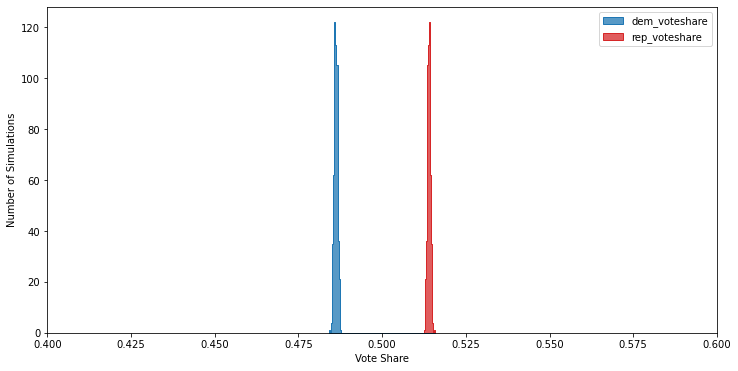

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    simulated_elections[["dem_voteshare", "rep_voteshare"]], element="step", bins=100, ax=ax, alpha=0.75
)
ax.set_xlabel("Vote Share")
ax.set_ylabel("Number of Simulations")
ax.set_xlim([0.4, 0.6])

In [10]:
shuffled_electorate = electorate.sample(frac=1).reset_index(drop=True)
poll_responders, poll_nonresponders = guaranteed_sample(max_num_attempts=5, screen_likely_voters=False)(
    1000, shuffled_electorate
)

In [15]:
poll_responders.head()

,age,education,turnout_likelihood,response_likelihood,candidate_preference,num_contact_attempts
0,23.557849,Post-College,0.5,0.5,Dem,2
1,34.543285,High School,0.5,0.1,Dem,1
2,98.310570,Post-College,0.5,0.5,Rep,2
3,18.072512,High School,0.5,0.1,Dem,4
4,30.493816,High School,0.5,0.1,Rep,5


In [22]:
responses_by_attempts = poll_responders.groupby(
    ["candidate_preference", "num_contact_attempts"], as_index=False
).size()

<AxesSubplot:xlabel='num_contact_attempts', ylabel='size'>

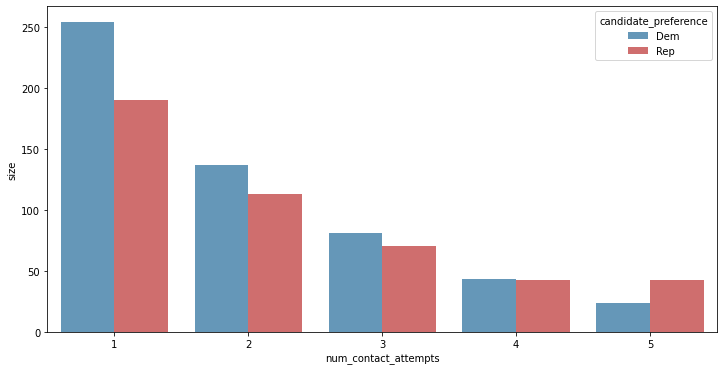

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=responses_by_attempts, x="num_contact_attempts", y="size", hue="candidate_preference", ax=ax, alpha=0.75)